# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [2]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000, # it was 10000 for the test 
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2
noise


0.005

#### Load Surrogate Models

In [4]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

#model_II = NN_Model()
#model_II.load_model(data_processor_II.config['MODEL_PATH'])  # Ensure this uses data_processor_II

# Define forward and gradient functions for the first configuration
forward_model = create_forward_model_function(data_processor_I, model_I)

# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test



# Define a custom Uniform random variable class

In [5]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):  
        if (self.pdf(x)!=0): 
            return np.log(self.pdf(x)) 
        else:
            return -np.inf
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [6]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print(x_true)
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) # ADDED

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
# = uniform(loc=np.array([0.1, -0.5, 29.0]), scale=np.array([0.5, 0.5, 31.0]) - np.array([0.1, -0.5, 29.0])) #ADDED
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 

        

[ 0.317228  0.314022 30.854021]


#### Perform least square optimization for each starting point

In [7]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    #covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31751377  0.31452715 30.81656249]
Optimized Params 2: [ 0.31749881  0.31450413 30.81784723]
Optimized Params 3: [ 0.31762219  0.31442163 30.83541946]
Optimized Params 4: [ 0.31685956  0.31561674 30.65624224]
Optimized Params 5: [ 0.31739266  0.31477061 30.78236421]


#### Do Metropolis Hastings Sampling

In [8]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, forward_model)
# random walk Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.1)

In [9]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []

# Iterate over each initial guess to set up and run the Markov chain sampler
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")

# Computing diagnostics and collecting results
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  

Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:31<00:00, 188.26it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 424.9
    Offset     float64 8B 395.7
    Thickness  float64 8B 404.9 

Sampling chain 1/1


Running chain, α = 0.23: 100%|██████████| 6000/6000 [00:32<00:00, 185.97it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 395.3
    Offset     float64 8B 390.6
    Thickness  float64 8B 387.4 

Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:31<00:00, 188.20it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 407.7
    Offset     float64 8B 389.3
    Thickness  float64 8B 409.1 

Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:31<00:00, 191.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 322.7
    Offset     float64 8B 307.3
    Thickness  float64 8B 289.1 

Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:32<00:00, 186.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 353.3
    Offset     float64 8B 419.1
    Thickness  float64 8B 435.1 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.002
    Offset     float64 8B 1.005
    Thickness  float64 8B 1.004


Let's look at the trace plot of one chain

# Diagnostics 

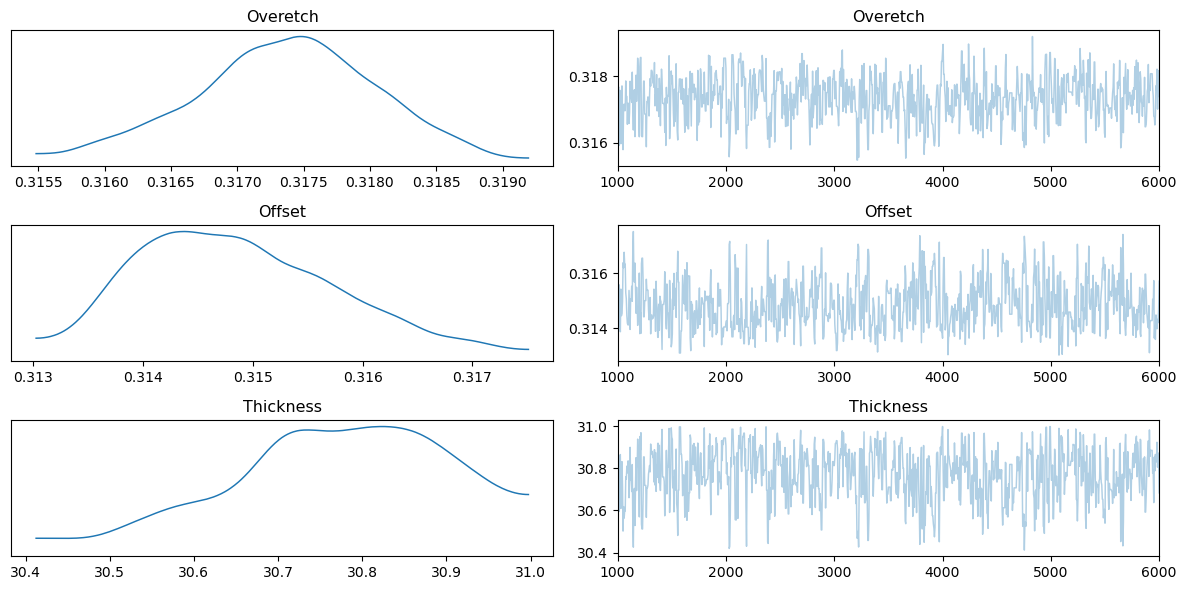

In [10]:
# Plot trace of the first set of samples
#idata = samples_mh[2].sel(draw=slice(MCMC_SETTINGS['Nb'], None,MCMC_SETTINGS['Nt']))
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()

plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

In [13]:
def plot_results(time, y_true, y_obs, forward_model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, forward_model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

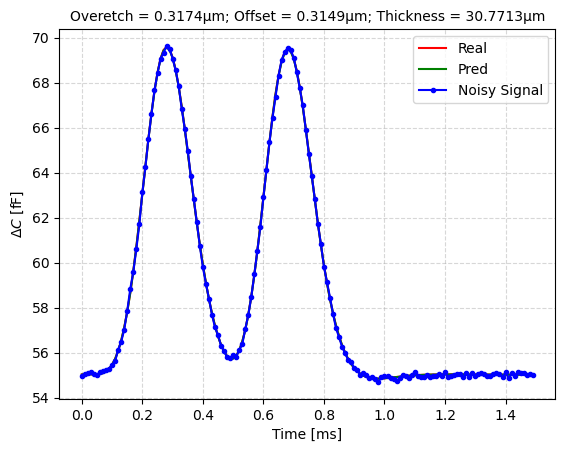

In [14]:
# Plotting and data collection
data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, forward_model(x_true), y_observed, forward_model, data)

Finally, let's look at the parameters distribution

In [15]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

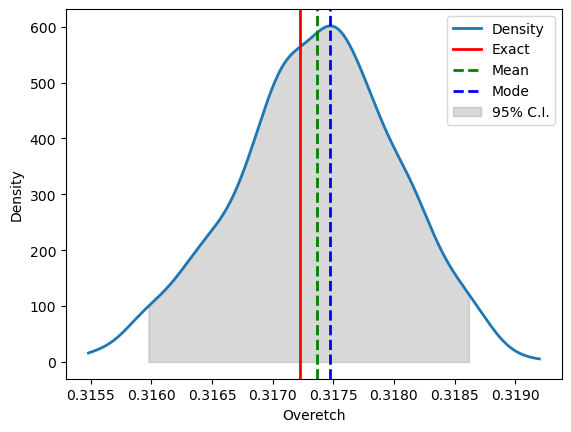

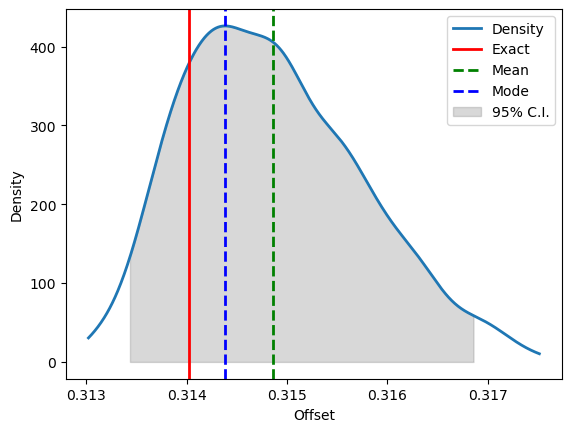

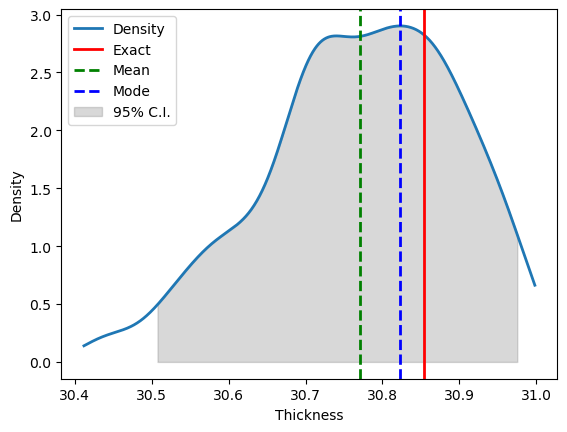

In [16]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [17]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

In [21]:

def plot_histograms(samples, true_params):

    num_params = samples.shape[0]
    param_names = ['Overetch', 'Offset', 'Thickness']

    sigma = [0.4,1,2]
    avgi = [0.3,0.0,30.0]
    sim_avg = ['Oavg','Uavg','Tavg']
    
    for i in range(num_params):
        plt.figure()
        n, bins, _ = plt.hist(samples[i, :], bins=50, density=True, color='skyblue', edgecolor='black')
        mean_value = np.mean(samples[i, :])
        ci_lower, ci_upper = np.percentile(samples[i, :], [5, 95])

        plt.axvline(true_params[i], color='darkred', linestyle='dashed', linewidth=3, label='True')
        plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=3, label='Mean')
        plt.fill_betweenx([0, max(n)], ci_lower, ci_upper, color='gray', alpha=0.35, label='95% CI')

        ratio_lower = (ci_lower-avgi[i]) / sigma[i]
        ratio_upper = (ci_upper-avgi[i]) / sigma[i]
        sym_lower = ""
        sym_upper = ""
        if ratio_lower>0:
            sym_lower = "+"
        if ratio_upper>0:
            sym_upper = "+"
        s = ['O','U','T']
        #plt.xticks([ci_lower,ci_upper],[sim_avg[i]+sym_lower+f'{ratio_lower:.4f} $\sigma_'+s[i]+'$',sim_avg[i]+sym_upper+f'{ratio_upper:.4f} $\sigma_'+s[i]+'$'])
        plt.xticks([ci_lower,ci_upper],[round(ci_lower,3), round(ci_upper,3)],fontsize = 11)
        plt.xlabel(param_names[i], fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

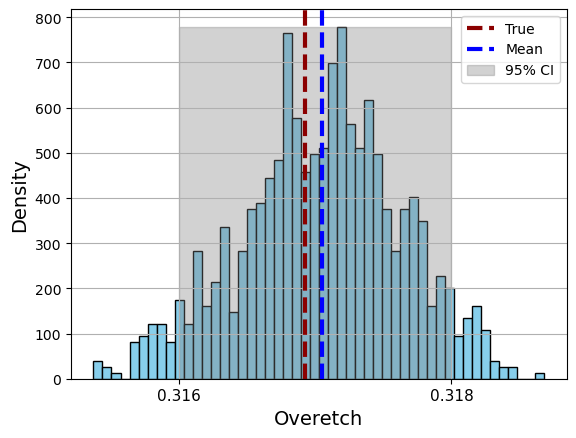

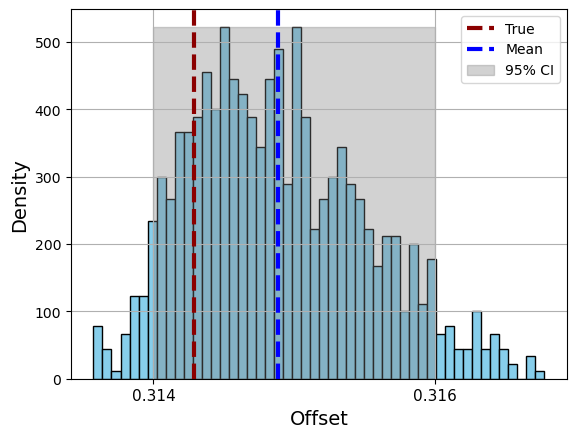

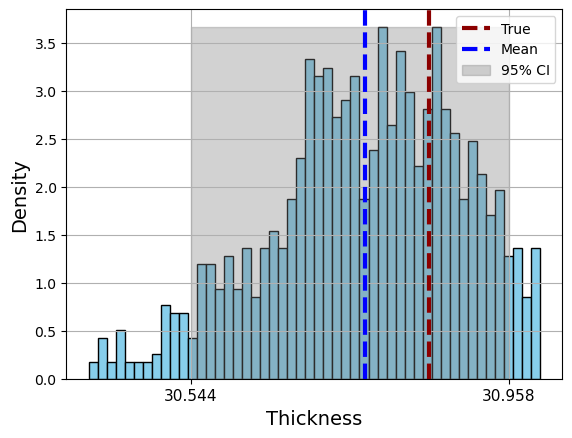

In [22]:
plot_histograms(samples, x_true)

ciao


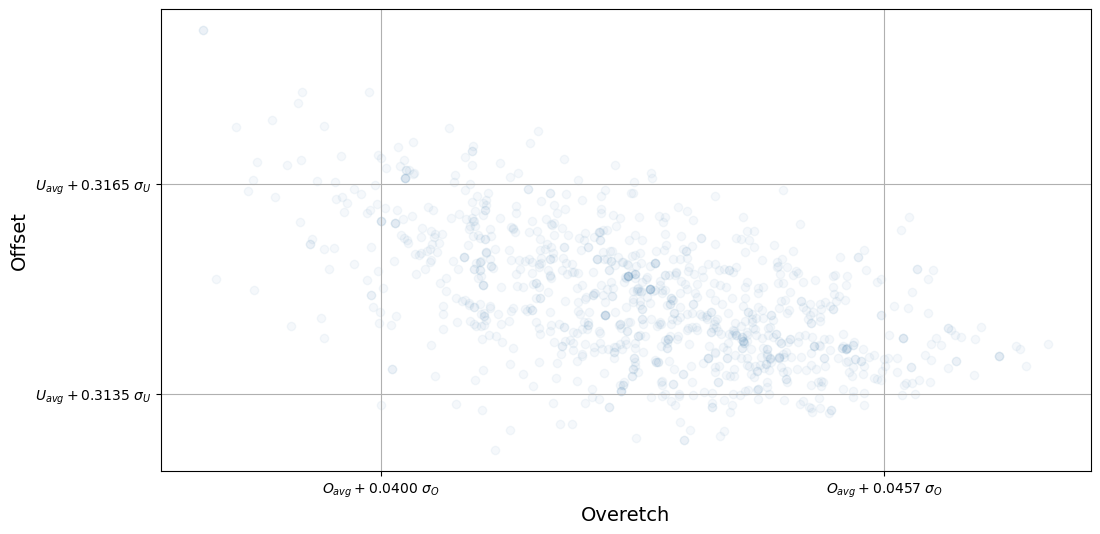

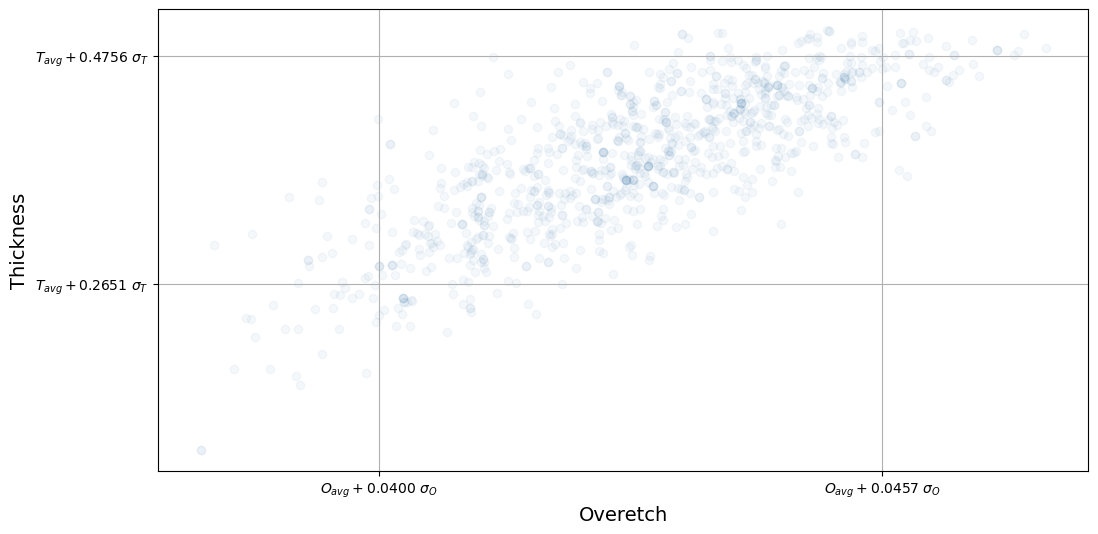

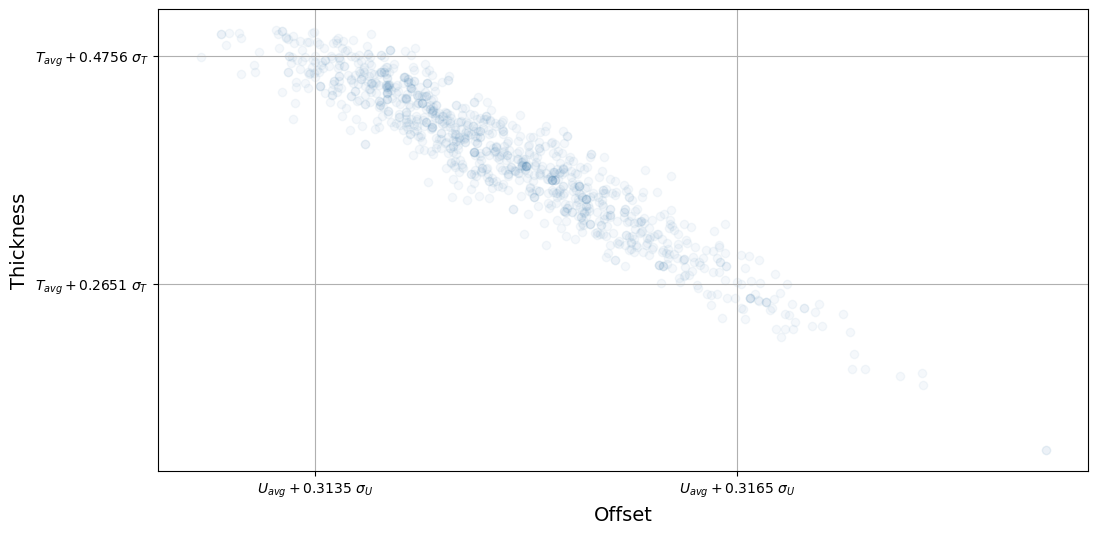

In [ ]:
plot_scatter(samples)

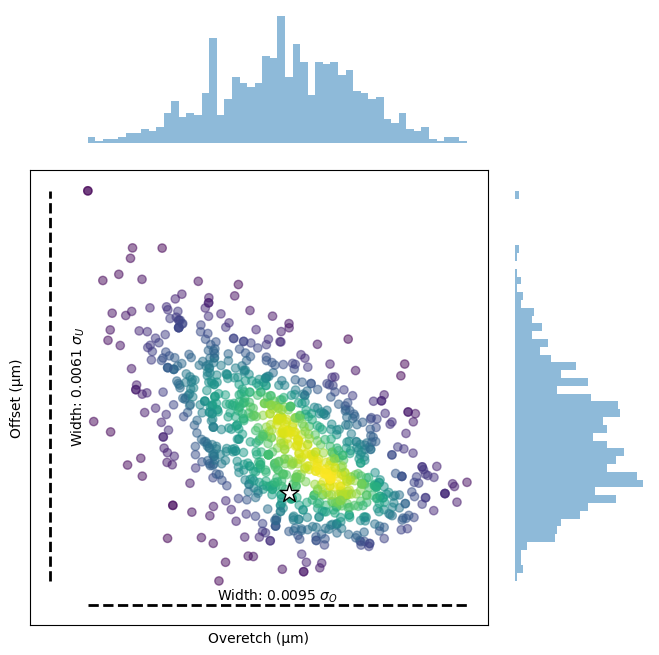

In [ ]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed


# See performance for 10 samples 

In [34]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, forward_model)
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.1) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    
print(samples_box[0][0])

The extracted samples are:  [125, 60, 53, 89, 9, 61, 156, 99, 92, 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:20<00:00, 295.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:20<00:00, 299.63it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:20<00:00, 296.28it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:20<00:00, 298.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α = 0.36: 100%|██████████| 6000/6000 [00:20<00:00, 299.60it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α = 0.39: 100%|██████████| 6000/6000 [00:20<00:00, 292.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α = 0.38: 100%|██████████| 6000/6000 [00:20<00:00, 298.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α = 0.39: 100%|██████████| 6000/6000 [00:20<00:00, 298.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α = 0.32: 100%|██████████| 6000/6000 [00:20<00:00, 295.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:20<00:00, 297.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[0.16394066 0.16455126 0.16349055 ... 0.16420977 0.16420977 0.16427192]


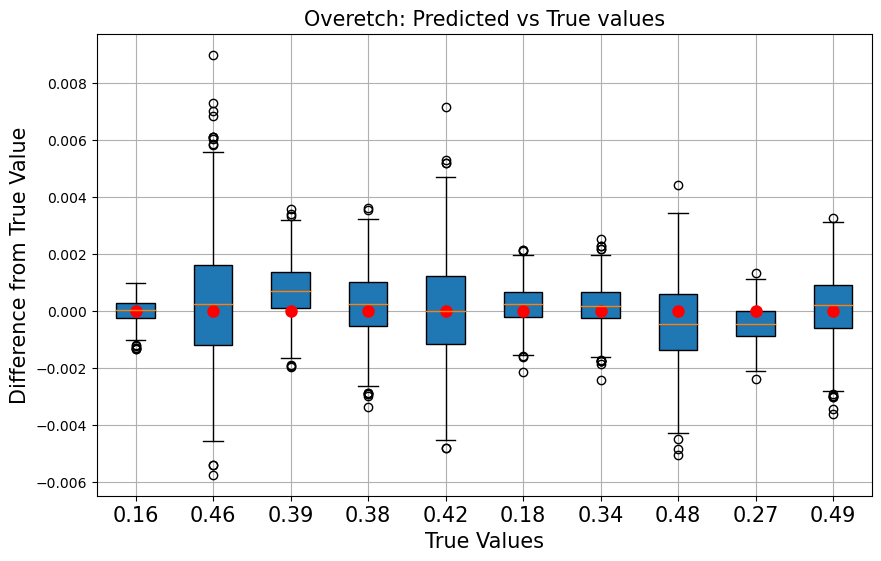

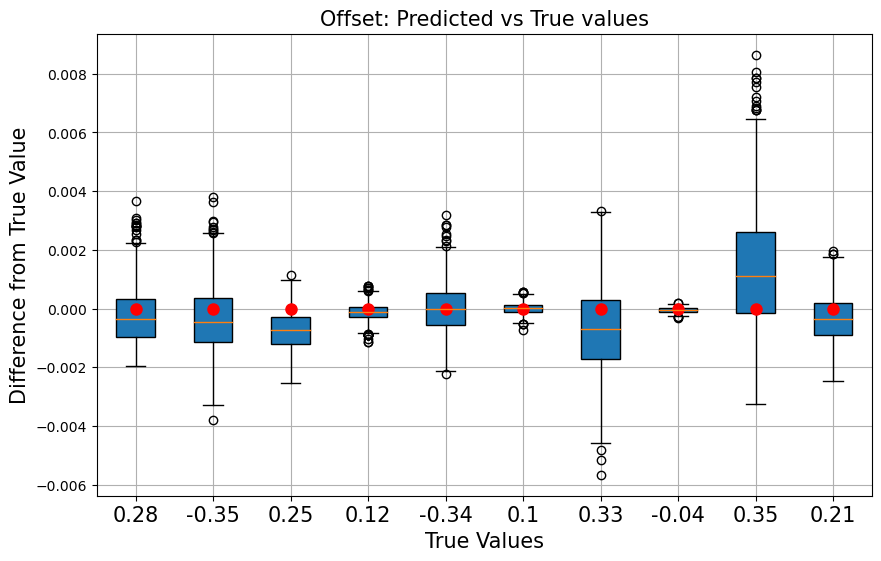

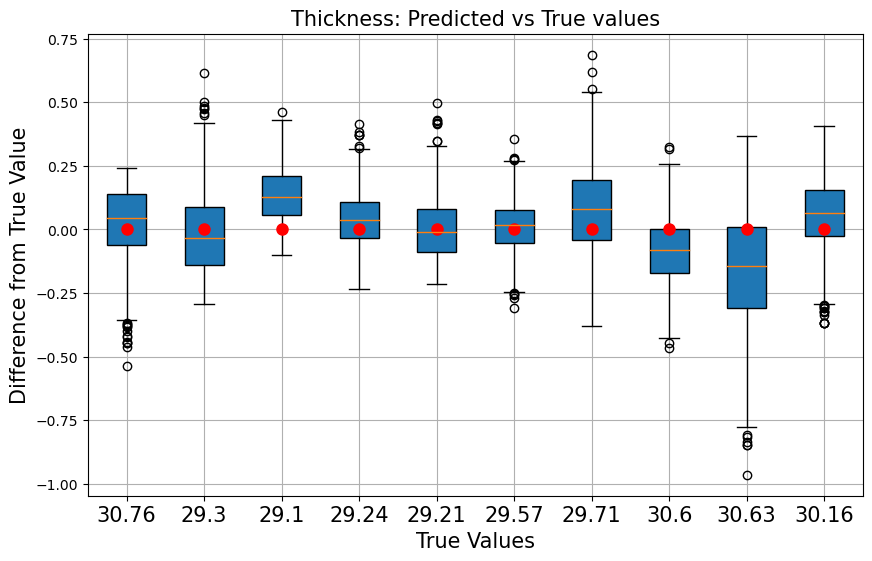

In [36]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()

### Parameters for violin plot 

In [39]:
np.random.seed(123)
random_samples = np.random.randint(0, 160, 25)
random_samples

array([109, 126,  66,  98,  17,  83, 106, 123,  57,  96, 113, 126,  47,
        73,  32, 111, 153,  83,  78,  96,  68,  49,  55,   2,  84])

In [ ]:
n = 10
print('The extracted samples are: ', random_samples)

Time_ESS = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, forward_model)
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.1) 

    # Perform the MH Algorithm 
    start = time.default
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    
print(samples_box[0][0])